In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.utils.data import sampler

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cuda')

In [3]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 252MB/s]


In [22]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])

aug_transform = T.Compose([
                T.ToTensor(),
                T.Resize(224),
                T.RandomHorizontalFlip(p=0.5),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

NUM_TRAIN = 49000

ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=aug_transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

Files already downloaded and verified
Files already downloaded and verified


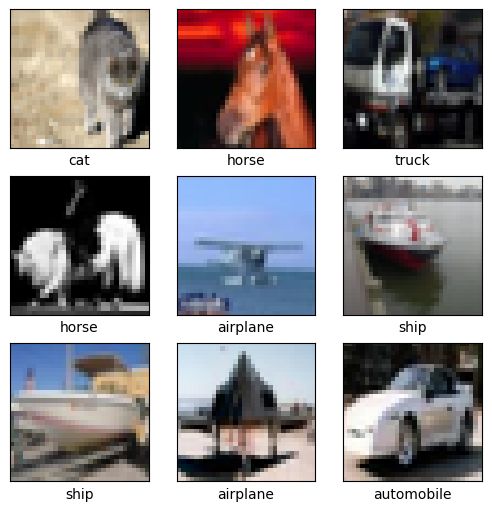

In [5]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                ax.set_xlabel(ds_train.classes[yh])

                if yh != y:
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

In [6]:
@torch.no_grad()
def eval_split(split, model, sample_size=None):
    model.eval()
    dl = splits[split]

    num_correct = 0
    num_sample = 0
    lossi = []
    i = 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

        i += len(xb)
        if sample_size and i >= sample_size:
            break

    accuracy = float(num_correct) / num_sample
    loss = torch.tensor(lossi).mean().item()
    model.train()

    return loss, accuracy

In [34]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

in_feature = model.fc.in_features

# model.fc = nn.Sequential(
#     nn.BatchNorm1d(in_feature),
#     nn.Linear(in_feature, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 10),
# )

model.fc = nn.Linear(in_feature, 10)

for p in model.layer4.parameters():
  p.requires_grad = True

print(f"parameter count: {sum([p.numel() for p in model.parameters()]):,}")


parameter count: 23,528,522


In [ ]:
%%time

model = model.to(device=device)
model.train()

dl = splits["train"]
epoch = 3
i = 0
n = len(dl) * epoch

metrics = []
update_ratio = []
optimizer = torch.optim.AdamW(model.parameters())

for _ in range(epoch):
    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 40 == 0:
            tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
            va_loss, va_acc = eval_split("valid", model, sample_size=1024)
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))
            print(f"{int(i/n*100)}%: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")
        
        i += 1
        optimizer.step()

0%: 2.39 2.42 0.10 0.09
1%: 0.67 0.74 0.80 0.78
3%: 0.50 0.60 0.83 0.81
5%: 0.72 0.79 0.78 0.77
6%: 0.51 0.56 0.82 0.82
8%: 0.35 0.44 0.88 0.86
10%: 0.38 0.49 0.88 0.85
12%: 0.38 0.41 0.87 0.85
13%: 0.39 0.50 0.87 0.84
15%: 0.33 0.42 0.89 0.86
17%: 0.34 0.37 0.89 0.88
19%: 0.38 0.46 0.87 0.85
20%: 0.34 0.40 0.88 0.87
22%: 0.32 0.43 0.89 0.86
24%: 0.40 0.49 0.87 0.83
26%: 0.28 0.38 0.91 0.89
27%: 0.30 0.37 0.90 0.89
29%: 0.33 0.38 0.89 0.87
31%: 0.22 0.36 0.92 0.88
33%: 0.23 0.34 0.92 0.89
34%: 0.22 0.34 0.92 0.88
36%: 0.23 0.34 0.92 0.89


60%: 0.53 0.62 0.82 0.78

In [27]:
tr_loss, tr_acc = eval_split("train", model)
va_loss, va_acc = eval_split("valid", model)

print(f"train: {tr_loss:.2f} {tr_acc:.2f}")
print(f"valid: {va_loss:.2f} {va_acc:.2f}")

train: 0.57 0.80
valid: 0.63 0.78


train: 0.57 0.80
valid: 0.63 0.78